In [1]:
import pandas as pd
import math
from Bio import SeqIO
from scipy import stats
import numpy as np

# 2-3-20 Sanger seq data analysis

Analysis of first ADAR de-amination experiments

## Data wrangling

Use tracy program to align and get base call intensities for Sanger reads

# To assign basecalls from Tracy basecall file to a reference nucleotide
        # start by assuming everything is a gap. Then if we encounter a gap in the
        # trace (alt) alignment skip one basepair in the reference. Without doing
        # this gaps in the alt alignment would cause the alignment to be off by
        # the total length of gaps compared to the basecalls
        
        # Tracy sort of put all this information together in its json output but the
        # alignments there are not the same as the basecalls within the json file
        # or from the output of basecall program so I am not sure what is going
        # on there so we have to put them together manually
        
        nuc_adds = ['-'] * len(basecalls)

        positions_added = 0

        for r, a in zip(ref, alt):
            if a == '-':
                continue
            else:
                nuc_adds[positions_added] = r
            positions_added += 1
        
        basecalls['ref_nuc'] = nuc_adds
        
        return basecalls

# WARNING WARNING WARNING

2-24-23 update: Trimming left or right alignment at all will break the assignment of peak values to reference bases because the program that converts gapped alignments to the final dataframe does not currently know about these trims. Tracy will not include the trimmed sections in the final gapped alignment so you get major offset issues. Fix this in future if needed

In [2]:
from pathlib import Path
import os
import json
import re

class trace():
    """Class which represents individual Sanger sequence trace (ab1 files).
    """

    def __init__(self, ab1_path, expected_conversion, ref, output_dir, 
                 insert, adar, rnaseh, sample_id, trim_left=0, trim_right=0,
                sample_name=None):
        self.ab1_path = Path(ab1_path)
        self.ref = Path(ref)
        self.expected_conversion = expected_conversion
        self.output_dir = Path(output_dir)
        self.insert = insert
        self.adar = adar
        self.rnaseh = rnaseh
        self.sample_id = sample_id
        self.trim_left = trim_left
        self.trim_right = trim_right
        self.sample_name = sample_name
    
    @property
    def basecall_file(self):
        return f'{self.output_dir.joinpath(self.ab1_path.stem)}.tracy.basecalls.tsv'
    
    @property
    def align_file(self):
        return f'{self.output_dir.joinpath(self.ab1_path.stem)}.tracy.align.json'
    

    def _tracy_basecall(self):
        """Use Tracy to generate basecalls from the provided abi file. Since
        we are lazy for now assume that Tracy is globally available.

        After the basecalls are saved to a tsv file read and return the results as
        a pandas dataframe.
        """

        cmd = f"tracy basecall -f tsv -o {str(self.basecall_file)} {str(self.ab1_path)}"
        os.system(cmd)

        return pd.read_csv(self.basecall_file, sep='\t')
    
    def _tracy_align(self, basecalls):
        
        cmd = f'tracy align -s 3 -l {self.trim_left} -r {self.trim_right} -f align -g {str(self.ref)} -o {self.align_file} {str(self.ab1_path)}'
        os.system(cmd)
        
        with open(str(self.align_file)) as handle:
            align_text = handle.read()
        
        # Use regex to pull out alignment text
        
        ref = ''.join(re.findall('Ref\s+\d+\s(.+)', align_text))
        alt = ''.join(re.findall('Alt\s+\d+\s(.+)', align_text))
        
        assert len(ref) == len(alt)
        # assert len(alt) == len(basecalls) does not seem to be the same 
        
        ref_bases = []
        
        #for i in range(len(ref)):
        #    if alt[i] == '-':
        #        # alignment is gapped here so this base should be removed from
        #        # the dataframe since it does not exist within the reference
        #        # symbolize this with -1 value at these locations
        #        ref_base[i] == -1
        #    elif ref[i] == '-':
        #        # if true there is a gap in the reference sequence. In this
        #        # case we need to skip over this region in the reference. 
        # I think an easier and better solution to all of this is to just mark
        # location where there is either a gap in the reference or the alignment
        # and just drop these location from the dataframe.
        
        ref_bases = []
        
        for i in range(len(ref)):
            if alt[i] == '-':
                continue
            elif ref[i] == '-':
                ref_bases.append('-')
            else:
                ref_bases.append(ref[i])
        
        basecalls['ref_nuc'] = ref_bases
        
        return basecalls
        
        
    

    def analyize(self):
        """This method is really the core functionality of the script. The idea being we will use
        the relative signal that is included as part of the Tracy basecalls in order to locate
        bases where editing may have occurred in some population of the molecules present in the
        Sanger sequencing reaction. 
        """

        # Call bases using Tracy
        basecalls = self._tracy_basecall()

        # ab1 files include 10 values per base. Tracy retains those values which is nice but to
        # simplify we will throw out rows that are not assigned to a nucleotide position. The
        # sites that are retained should be the peak crests

        bc_trim = basecalls.loc[~basecalls['basenum'].isna()]

        assert len(bc_trim) > 0
        
        
        bc_trim_ref = self._tracy_align(bc_trim)
        
        
        bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
        bc_trim_ref['sum_signal'] = bc_trim_ref['peakA'] + bc_trim_ref['peakT'] + bc_trim_ref['peakG'] + bc_trim_ref['peakC']        
        bc_trim_ref['ADAR'] = self.adar
        bc_trim_ref['insert'] = self.insert
        bc_trim_ref['rnaseh'] = self.rnaseh
        bc_trim_ref['sample_ID'] = self.sample_id
        bc_trim_ref['sample_name'] = self.sample_name


        return bc_trim_ref

Read ab1 trace files.

In [3]:
reads_dir = Path('../sangerSeq/2-3-23/2023-02-03_827248')

reads = [p for p in reads_dir.iterdir() if p.suffix == '.ab1']

reads

[PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-16_VRI_1__2023-02-04_H04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-13_VRI_1__2023-02-04_E04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-7_VRI_1__2023-02-04_C04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-8_VRI_1__2023-02-04_D04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-15_VRI_1__2023-02-04_G04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1')]

In [4]:
reads_list = []

for r in reads:
    reads_list.append(
    {
        'ab1_path': str(r),
        'sample_ID': int(r.stem.split('_VRI')[0].split('-')[-1])
    }
    
    )
reads_df = pd.DataFrame(reads_list)
reads_df

ab1_path  sample_ID
0  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         14
1  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         16
2  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          6
3  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         13
4  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          7
5  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          8
6  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         15
7  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          5

Reads template files.

In [5]:
templates = [p for p in Path('../templates/shifted').iterdir() if p.suffix == '.fa']

templates

[PosixPath('../templates/shifted/VR-22.shifted.fa'),
 PosixPath('../templates/shifted/VR-26.shifted.fa'),
 PosixPath('../templates/shifted/VR-23.shifted.fa')]

### 2-7-22 Update

Closer inspection of the alignment files showed that the VR regions within the reads were not aligning to the reference despite being the correct sequnece. 

In sample 5 the first motif that aligns is `AATTCGTCGCA` which occurs at the end of the VR insert. However, looking at the reference fasta file used for the alignment this is exactly the start of the reference sequence. It appears that Tracy is unable to do circular alignments and the "start" position of the reference has prevented alignment of the VR region. 

So I manually created fasta files that started ~500 bp downstream of the original reference start location to avoid this issue. These files have a `.shifted` extension and should *not* be used for anything else besides this specific sanger alignment.

In [6]:
temps = []

for path in templates:
        temps.append({
            'name': path.stem,
            'path': str(path),
            'insert': int(path.stem.split('VR-')[-1].split('.')[0])

        })
template_df = pd.DataFrame(temps)
template_df

name                                   path  insert
0  VR-22.shifted  ../templates/shifted/VR-22.shifted.fa      22
1  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa      26
2  VR-23.shifted  ../templates/shifted/VR-23.shifted.fa      23

Read sample assignments into table

In [7]:
samples = pd.read_csv('../sampleTables/ADAR-IVT-samples.csv')

In [8]:
samples.head()

sample_ID       tube_label  insert txn RnaseH ADAR_species IVT_date  \
0          1  23 ADAR2 -RH A-      23   +      -            -  1-31-23   
1          2  23 ADAR2 +RH A-      23   +      +            -  1-31-23   
2          3  23 ADAR1 -RH A-      23   +      -            -  1-31-23   
3          4  23 ADAR1 +RH A-      23   +      +            -  1-31-23   
4          5  23 ADAR2 -RH A+      23   +      -            2  1-31-23   

  ADAR_treatment_date     fwd_primer     rev_primer  \
0             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
1             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
2             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
3             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
4             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   

                                      fwd_primer_seq  \
0  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
1  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
2  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
3  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
4  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   

                                      rev_primer_seq pcr_date  num_cycles  \
0  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
1  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
2  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
3  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
4  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   

   anneal_temp  ext_time  pcr_rxn_volume  
0           72        90              20  
1           72        90              20  
2           72        90              20  
3           72        90              20  
4           72        90              20

In [9]:
samples = samples.merge(template_df, on='insert')

Turn samples dataframe into trace objects. First select samples that were sequenced

In [10]:
exp_1_df = reads_df.merge(samples, on='sample_ID')
exp_1_df.head()

ab1_path  sample_ID  \
0  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         14   
1  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         16   
2  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          6   
3  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...         13   
4  ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...          7   

        tube_label  insert txn RnaseH ADAR_species IVT_date  \
0  22 ADAR2 +RH A+      22   +      +            2  1-31-23   
1  22 ADAR1 -RH A+      22   +      -            1  1-31-23   
2  23 ADAR2 +RH A+      23   +      +            2  1-31-23   
3  22 ADAR2 -RH A+      22   +      -            2  1-31-23   
4  23 ADAR1 +RH A+      23   +      +            1  1-31-23   

  ADAR_treatment_date     fwd_primer     rev_primer  \
0             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
1             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
2             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
3             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   
4             1-31-23  PacBioFwdV2-0  PacBioRevV2-0   

                                      fwd_primer_seq  \
0  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
1  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
2  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
3  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   
4  GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...   

                                      rev_primer_seq pcr_date  num_cycles  \
0  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
1  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
2  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
3  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   
4  ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...   2-1-23          30   

   anneal_temp  ext_time  pcr_rxn_volume           name  \
0           72        90              20  VR-22.shifted   
1           72        90              20  VR-22.shifted   
2           72        90              20  VR-23.shifted   
3           72        90              20  VR-22.shifted   
4           72        90              20  VR-23.shifted   

                                    path  
0  ../templates/shifted/VR-22.shifted.fa  
1  ../templates/shifted/VR-22.shifted.fa  
2  ../templates/shifted/VR-23.shifted.fa  
3  ../templates/shifted/VR-22.shifted.fa  
4  ../templates/shifted/VR-23.shifted.fa

In [11]:
Path('sanger-1').mkdir(exist_ok=True)

In [12]:
traces = []

for i, row in exp_1_df.iterrows():
    traces.append(
        trace(
            row.ab1_path, ('T', 'C'), 
            row.path, 
            'sanger-1', 
            row.insert, 
            row.ADAR_species, 
            row.RnaseH,
            row.sample_ID)
    )

In [13]:
basecalls = traces[0]._tracy_basecall()
bc_trim = basecalls.loc[~basecalls['basenum'].isna()]

len(bc_trim)

[2023-Feb-27 13:23:25] tracy basecall -f tsv -o sanger-1/ADAR-IVT-14_VRI_1__2023-02-04_F04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1 
[2023-Feb-27 13:23:25] Done.


1000

In [14]:
# calls, ref, alt = traces[0]._tracy_align(bc_trim)

longer due to gaps

In [15]:
trace_data = []

for each_trace in traces:
    trace_data.append(each_trace.analyize())

[2023-Feb-27 13:23:25] tracy basecall -f tsv -o sanger-1/ADAR-IVT-14_VRI_1__2023-02-04_F04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1 
[2023-Feb-27 13:23:25] Done.
[2023-Feb-27 13:23:25] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-22.shifted.fa -o sanger-1/ADAR-IVT-14_VRI_1__2023-02-04_F04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1 
[2023-Feb-27 13:23:25] Load ab1 file
[2023-Feb-27 13:23:25] Load FASTA reference
[2023-Feb-27 13:23:25] Find reference match
[2023-Feb-27 13:23:25] Alignment
[2023-Feb-27 13:23:25] Output
[2023-Feb-27 13:23:25] Done.
[2023-Feb-27 13:23:25] tracy basecall -f tsv -o sanger-1/ADAR-IVT-16_VRI_1__2023-02-04_H04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-16_VRI_1__2023-02-04_H04.ab1 
[2023-Feb-27 13:23:25] Done.
[2023-Feb-27 13:23:25] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-22.shifted.fa -o sanger

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[2023-Feb-27 13:23:25] Output
[2023-Feb-27 13:23:25] Done.
[2023-Feb-27 13:23:25] tracy basecall -f tsv -o sanger-1/ADAR-IVT-6_VRI_1__2023-02-04_B04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1 
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-23.shifted.fa -o sanger-1/ADAR-IVT-6_VRI_1__2023-02-04_B04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1 
[2023-Feb-27 13:23:26] Load ab1 file
[2023-Feb-27 13:23:26] Load FASTA reference
[2023-Feb-27 13:23:26] Find reference match
[2023-Feb-27 13:23:26] Alignment
[2023-Feb-27 13:23:26] Output
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy basecall -f tsv -o sanger-1/ADAR-IVT-13_VRI_1__2023-02-04_E04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-13_VRI_1__2023-02-04_E04.ab1 
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy align -s 3 -l 0 -r 0 -f a

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[2023-Feb-27 13:23:26] Output
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy basecall -f tsv -o sanger-1/ADAR-IVT-8_VRI_1__2023-02-04_D04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-8_VRI_1__2023-02-04_D04.ab1 
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-23.shifted.fa -o sanger-1/ADAR-IVT-8_VRI_1__2023-02-04_D04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-8_VRI_1__2023-02-04_D04.ab1 
[2023-Feb-27 13:23:26] Load ab1 file
[2023-Feb-27 13:23:26] Load FASTA reference
[2023-Feb-27 13:23:26] Find reference match
[2023-Feb-27 13:23:26] Alignment
[2023-Feb-27 13:23:26] Output
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy basecall -f tsv -o sanger-1/ADAR-IVT-15_VRI_1__2023-02-04_G04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-15_VRI_1__2023-02-04_G04.ab1 
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy align -s 3 -l 0 -r 0 -f a

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[2023-Feb-27 13:23:26] Output
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy basecall -f tsv -o sanger-1/ADAR-IVT-5_VRI_1__2023-02-04_A04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1 
[2023-Feb-27 13:23:26] Done.
[2023-Feb-27 13:23:26] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-23.shifted.fa -o sanger-1/ADAR-IVT-5_VRI_1__2023-02-04_A04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1 
[2023-Feb-27 13:23:26] Load ab1 file
[2023-Feb-27 13:23:26] Load FASTA reference
[2023-Feb-27 13:23:26] Find reference match
[2023-Feb-27 13:23:26] Alignment
[2023-Feb-27 13:23:26] Output
[2023-Feb-27 13:23:26] Done.


/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Remove outlier peaks from the dataframe using IQR method. This removes peaks with very low or very high signal from each read

In [16]:
def remove_outlier_peaks(df):
    return df[(np.abs(stats.zscore(df['sum_signal'])) < 3)]


trace_data_prune = []

for each_frame in trace_data:
    trace_data_prune.append(remove_outlier_peaks(each_frame))

len(trace_data_prune)

8

Combine dataframes

In [17]:
all_trace_df = pd.concat(trace_data_prune)

In [18]:
all_trace_df.head()

pos  peakA  peakC  peakG  peakT  basenum primary secondary consensus  \
205  206      1    585    278   1267     19.0       T         T         T   
219  220    282   1937    217    235     20.0       C         C         C   
231  232    230   1513    521    328     21.0       G         G         G   
237  238    152   1411    344    567     22.0       T         T         T   
256  257    111    177    162   1291     23.0       T         T         T   

     qual trim ref_nuc  conversion_ratio  sum_signal ADAR  insert rnaseh  \
205  15.0    Y       C          0.315875        2131    2      22      +   
219  24.0    Y       C          0.891805        2671    2      22      +   
231   6.0    Y       -          0.821836        2592    2      22      +   
237   7.0    Y       -          0.713347        2474    2      22      +   
256  13.0    Y       T          0.120572        1741    2      22      +   

     sample_ID sample_name  
205         14        None  
219         14        None  
231         14        None  
237         14        None  
256         14        None

## Analysis

### Determine the C / C + T value at locations that should be T according to the aligned reference sequence

In [19]:
all_trace_df_T = all_trace_df.loc[all_trace_df['ref_nuc'] == 'T']

In [20]:
all_trace_df_T

pos  peakA  peakC  peakG  peakT  basenum primary secondary consensus  \
256      257    111    177    162   1291     23.0       T         T         T   
502      503    323    323      2    881     43.0       T         M         N   
524      525    251    301     78    923     45.0       T         C         N   
730      731     27     71    249    634     63.0       T         G         N   
814      815     54     43    374   1322     72.0       T         T         T   
...      ...    ...    ...    ...    ...      ...     ...       ...       ...   
11298  11299      2      0     14     21    949.0       T         G         N   
11663  11664      5      0      6     17    980.0       T         G         N   
11812  11813      0      1      2     30    993.0       T         T         T   
11819  11820      0      0      5     36    994.0       T         T         T   
11856  11857      2      8      2     39    997.0       T         T         T   

       qual trim ref_nuc  conversion_ratio  sum_signal ADAR  insert rnaseh  \
256    13.0    Y       T          0.120572        1741    2      22      +   
502    13.0    Y       T          0.268272        1529    2      22      +   
524    19.0    Y       T          0.245915        1553    2      22      +   
730    13.0    Y       T          0.100709         981    2      22      +   
814    39.0    Y       T          0.031502        1793    2      22      +   
...     ...  ...     ...               ...         ...  ...     ...    ...   
11298  19.0    Y       T          0.000000          37    2      23      -   
11663  23.0    Y       T          0.000000          28    2      23      -   
11812  31.0    Y       T          0.032258          33    2      23      -   
11819  25.0    Y       T          0.000000          41    2      23      -   
11856  32.0    Y       T          0.170213          51    2      23      -   

       sample_ID sample_name  
256           14        None  
502           14        None  
524           14        None  
730           14        None  
814           14        None  
...          ...         ...  
11298          5        None  
11663          5        None  
11812          5        None  
11819          5        None  
11856          5        None  

[1558 rows x 19 columns]

In [21]:
all_trace_df.to_csv('fluorescenceValuesAndAlignmentsAllSamples.csv')

Plot this ratio for each condition

In [22]:
%load_ext rpy2.ipython

In [23]:
%%R

library(ggplot2)
library(ggpubr)

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: Saving 15 x 5 in image



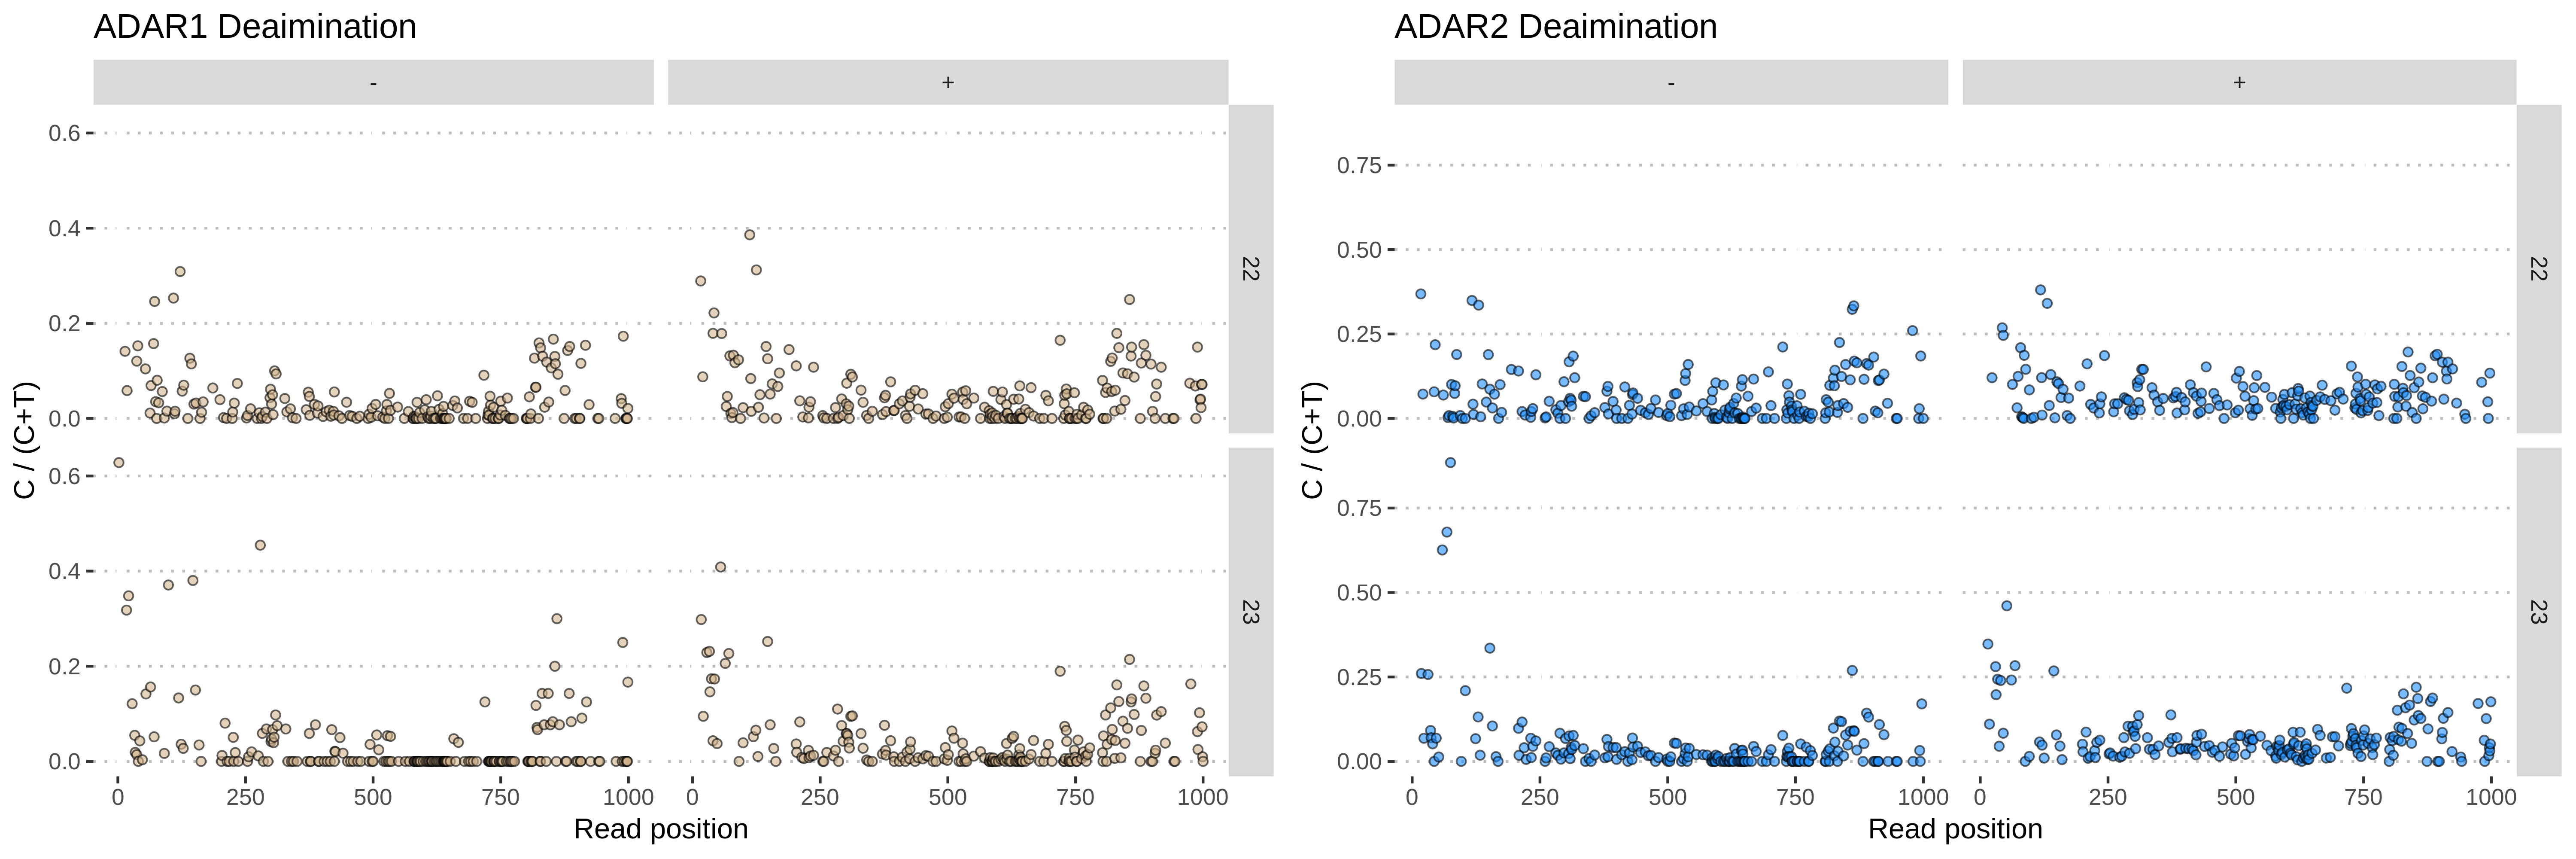

In [24]:
%%R -i all_trace_df_T -w 15 -h 5 --units in -r 400

adar1.df <- subset(all_trace_df_T, ADAR==1)
adar2.df <- subset(all_trace_df_T, ADAR==2)

adar1.plt <- ggplot(adar1.df, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='tan', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) + theme_pubclean() +
        labs(y='C / (C+T)', x='Read position', title='ADAR1 Deaimination')

adar2.plt <- ggplot(adar2.df, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='dodgerblue', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) + theme_pubclean() +
        labs(y='C / (C+T)', x='Read position', title='ADAR2 Deaimination')

plt.1 <- ggarrange(adar1.plt, adar2.plt)
ggsave('plots/global_C_to_T_ratio.png', plt.1, dpi=300)
plt.1

## Determine conversion ratios at "CTA" sites which should be the best editing canidates

In [25]:
def identify_cta_sites(df):
    # Determine the row numbers of "T" nucleotides in a reference that are part of a CTA site
    # and only return those rows
    ref_nucs = ''.join(list(df['ref_nuc']))
    finds = re.finditer('CTA', ref_nucs)
    CTA_T_rows = []
    for f in finds:
        CTA_T_rows.append(f.span()[0]+1)
    return df.iloc[CTA_T_rows]

In [26]:
CTA_sites = identify_cta_sites(all_trace_df)

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: Saving 15 x 5 in image



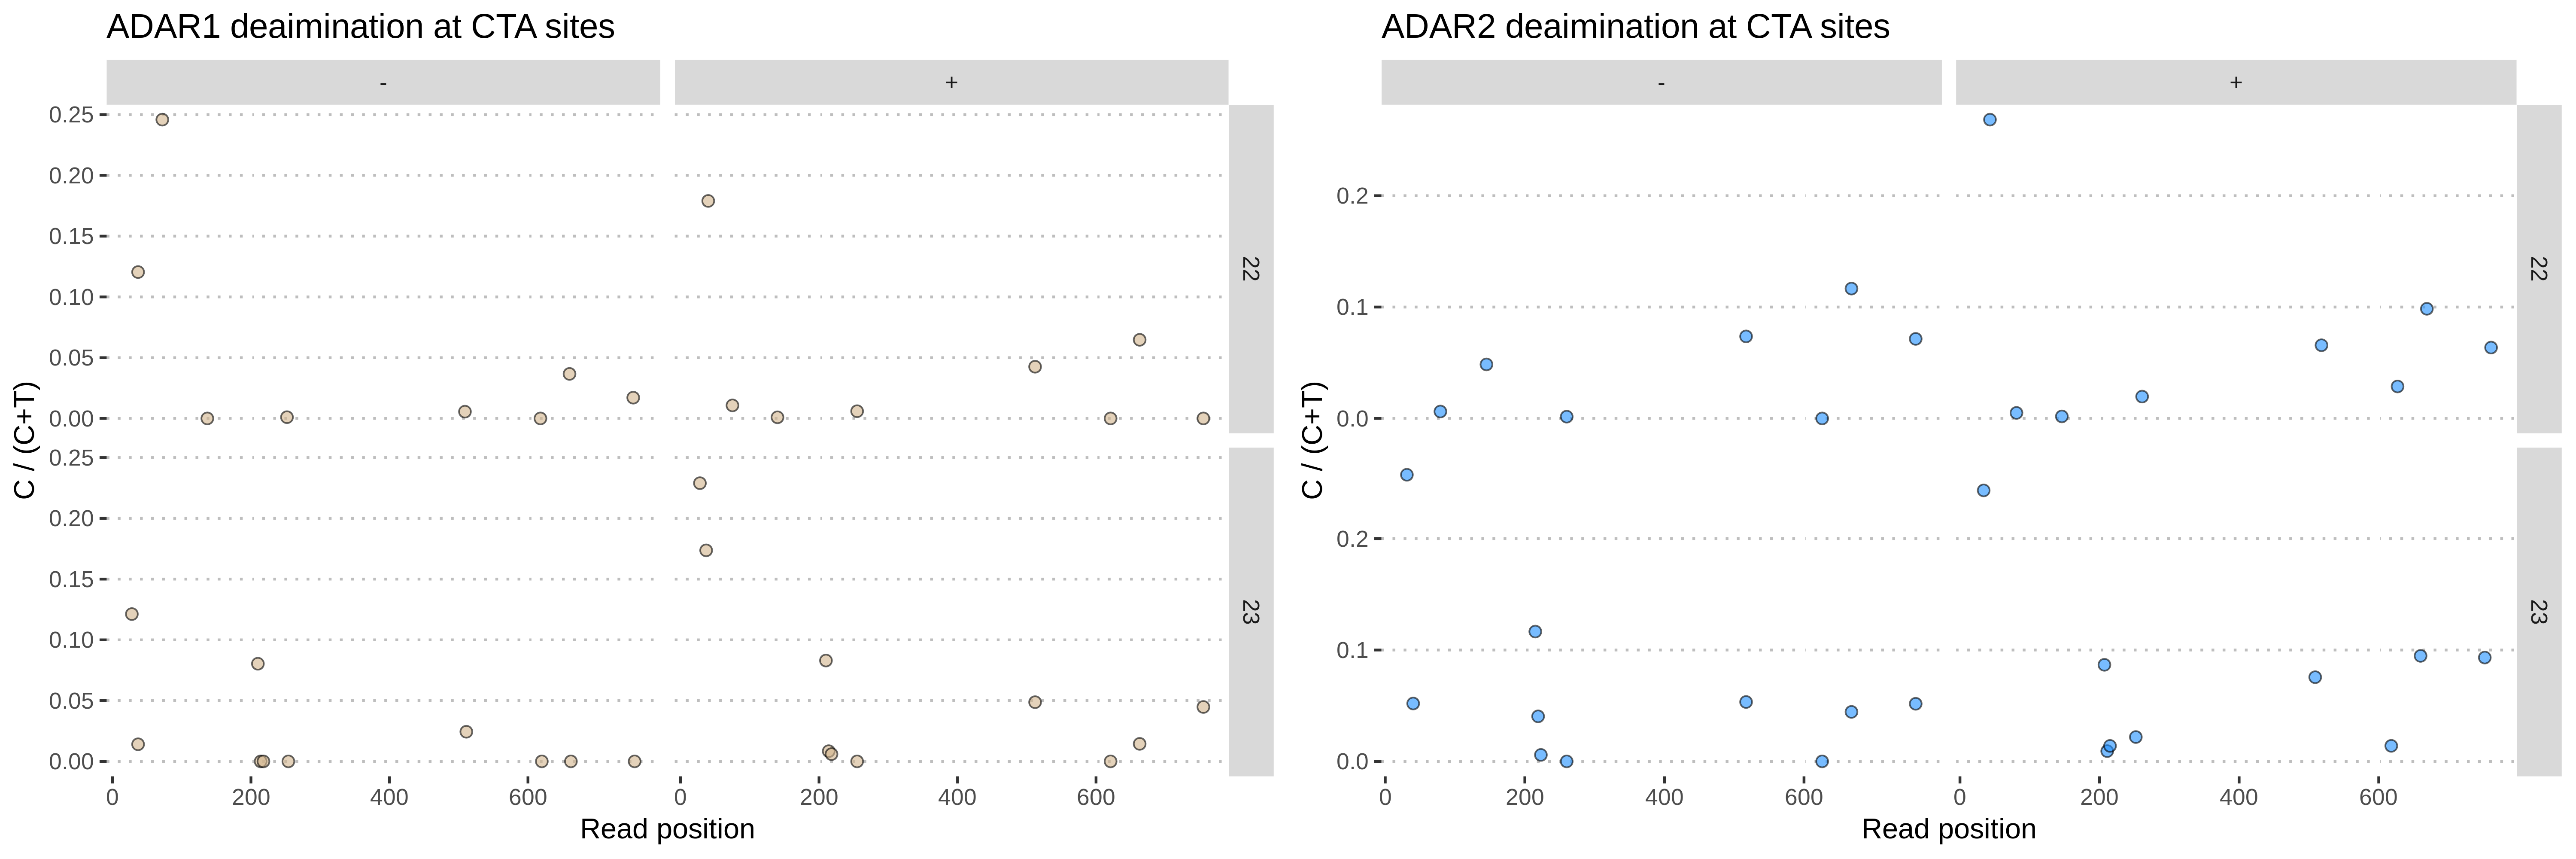

In [27]:
%%R -i CTA_sites -w 15 -h 5 --units in -r 400

adar1.df.cta <- subset(CTA_sites, ADAR==1)
adar2.df.cta <- subset(CTA_sites, ADAR==2)

adar1.plt.cta <- ggplot(adar1.df.cta, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', size=2, pch=21, fill='tan', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) +
        labs(y='C / (C+T)', x='Read position', title='ADAR1 deaimination at CTA sites') + theme_pubclean()

adar2.plt.cta <- ggplot(adar2.df.cta, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', size=2, pch=21, fill='dodgerblue', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) +
        labs(y='C / (C+T)', x='Read position', title='ADAR2 deaimination at CTA sites') + theme_pubclean()

plt2 <- ggarrange(adar1.plt.cta, adar2.plt.cta)
ggsave('plots/C_to_T_ratio_at_CTA_sites.png', plt2, dpi=300)
plt2

Check an individual sample

In [28]:
CTA_sites_s14 = CTA_sites.loc[CTA_sites['sample_ID'] == 13]

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


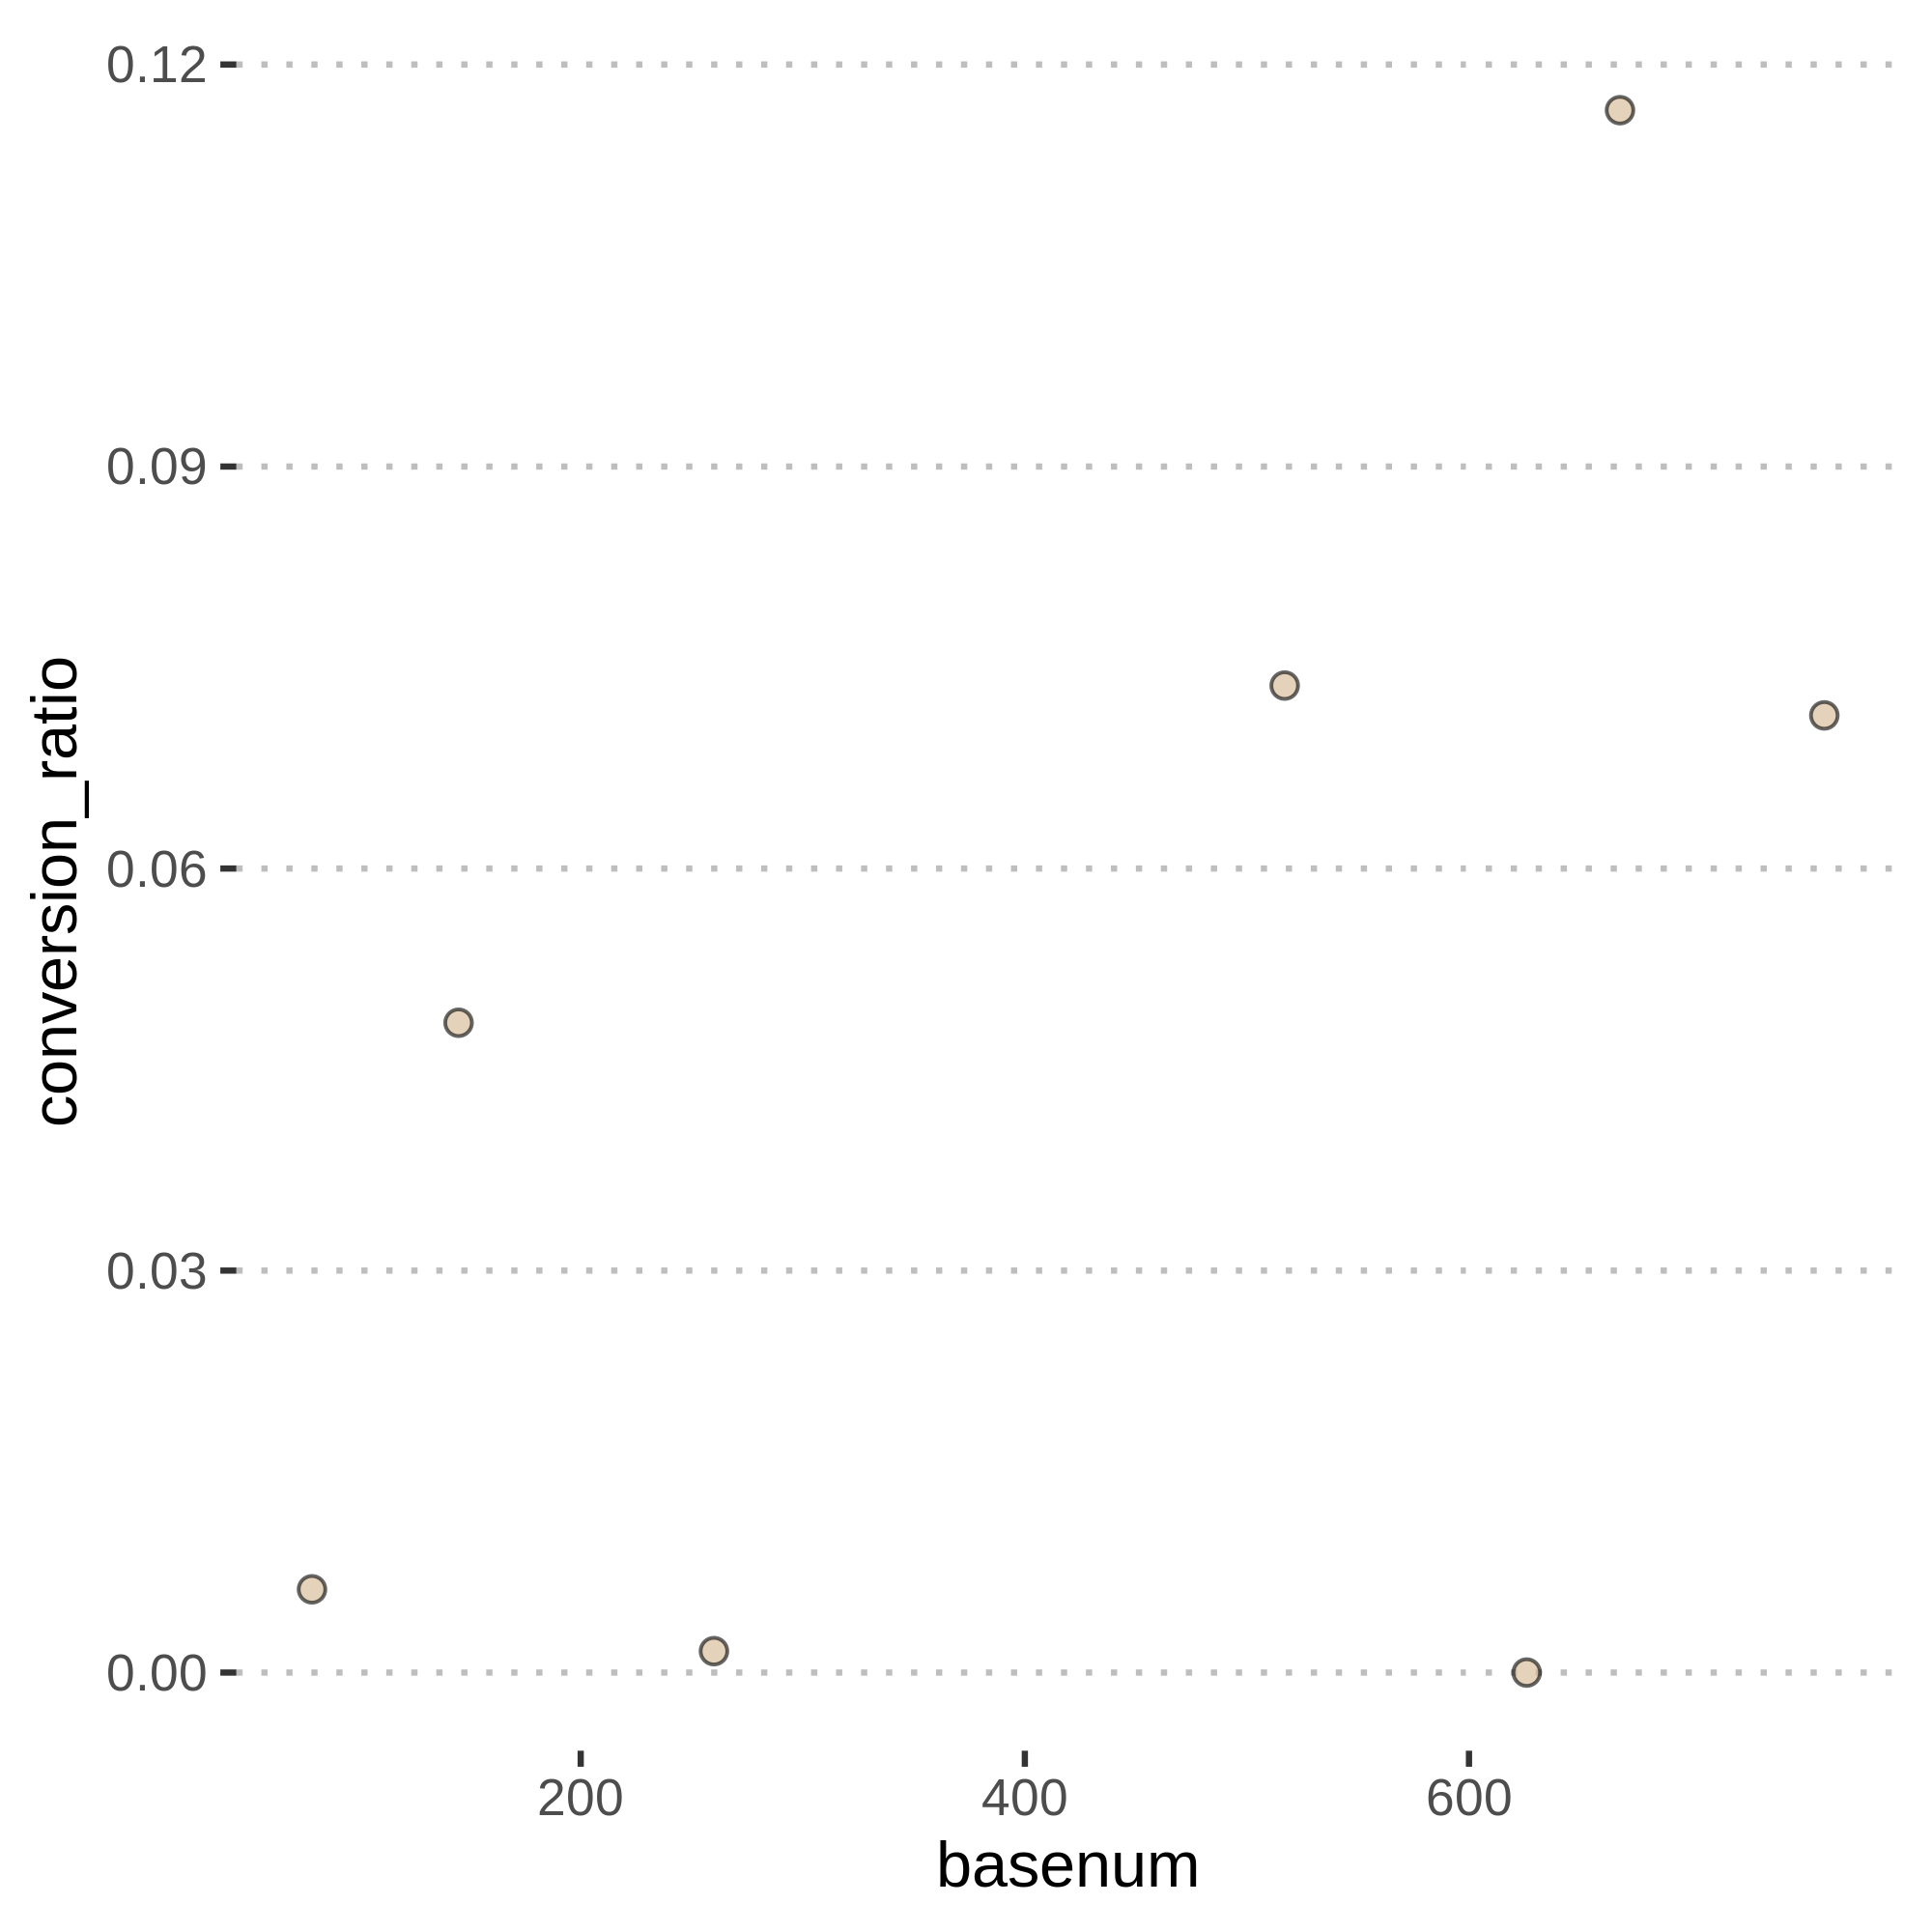

In [29]:
%%R -i CTA_sites_s14 -w 5 -h 5 --units in -r 400

adar1.plt.cta.14 <- ggplot(CTA_sites_s14, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', size=2, pch=21, fill='tan', alpha=0.6) + theme_pubclean()
adar1.plt.cta.14

# 2-22-23 Sanger analysis

### Read trace data

In [30]:
trace_dir = Path('../sangerSeq/2-23-23/2023-02-22_831671')

reads_2 = [p for p in trace_dir.iterdir() if '.ab1' in p.suffix]

reads_2

[PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-FLEQ-N_ADAR_FWD__2023-02-23_A11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-2_FanHitter-1__2023-02-23_D11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-3_FanHitter-1__2023-02-23_E11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-10_FanHitter-1__2023-02-23_G11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-11_FanHitter-1__2023-02-23_H11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-FLEQ-O_ADAR_FWD__2023-02-23_B11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-4_FanHitter-1__2023-02-23_F11.ab1'),
 PosixPath('../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-1_FanHitter-1__2023-02-23_C11.ab1')]

Create pandas formated list of reads

In [31]:
reads_list_2 = []

for r in reads_2:
    try:
        reads_list_2.append(
        {
            'ab1_path': str(r),
            'sample_ID': int(r.stem.split('_')[0].split('-')[-1])
        }
    )
    except ValueError as e:
            # Do not include positive controls because do not currently have template
            # for them
            print('Did not include', r.stem)
    
        
reads_2_df = pd.DataFrame(reads_list_2)
reads_2_df

Did not include ADAR-FLEQ-N_ADAR_FWD__2023-02-23_A11
Did not include ADAR-FLEQ-O_ADAR_FWD__2023-02-23_B11


ab1_path  sample_ID
0  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          2
1  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          3
2  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...         10
3  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...         11
4  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          4
5  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          1

Read sample dataframe for these guys.

In [32]:
samples_2 = pd.read_csv('../sampleTables/ADAR-IVT-samples-sanger-2.csv')
samples_2

sample_ID     tube_label  insert  txn RnaseH ADAR_species  IVT_date  \
0           1  IDEQ + TXN -       26    -      -         IDEQ       NaN   
1           2   IDEQ + TXN +      26    +      -         IDEQ       NaN   
2           3     IDEQ + RH+      26    +      +         IDEQ       NaN   
3           4   IDEQ – TNX -      26    -      -            -       NaN   
4           5            NaN      26  NaN    NaN          NaN       NaN   
5           6            NaN      26  NaN    NaN          NaN       NaN   
6           7            NaN      26  NaN    NaN          NaN       NaN   
7           8            NaN      26  NaN    NaN          NaN       NaN   
8           9            NaN      26  NaN    NaN          NaN       NaN   
9          10   FLEQ + TXN +      26    +    NaN         FLEQ       NaN   
10         11   FLEQ – TXN -      26    -    NaN            -       NaN   
11         12            NaN      26  NaN    NaN          NaN       NaN   
12         13            NaN       0  NaN    NaN          NaN       NaN   
13         14            NaN       0  NaN    NaN          NaN       NaN   

    ADAR_treatment_date  fwd_primer  rev_primer  fwd_primer_seq  \
0                   NaN         NaN         NaN             NaN   
1                   NaN         NaN         NaN             NaN   
2                   NaN         NaN         NaN             NaN   
3                   NaN         NaN         NaN             NaN   
4                   NaN         NaN         NaN             NaN   
5                   NaN         NaN         NaN             NaN   
6                   NaN         NaN         NaN             NaN   
7                   NaN         NaN         NaN             NaN   
8                   NaN         NaN         NaN             NaN   
9                   NaN         NaN         NaN             NaN   
10                  NaN         NaN         NaN             NaN   
11                  NaN         NaN         NaN             NaN   
12                  NaN         NaN         NaN             NaN   
13                  NaN         NaN         NaN             NaN   

    rev_primer_seq  pcr_date  num_cycles  anneal_temp  ext_time  \
0              NaN       NaN         NaN          NaN       NaN   
1              NaN       NaN         NaN          NaN       NaN   
2              NaN       NaN         NaN          NaN       NaN   
3              NaN       NaN         NaN          NaN       NaN   
4              NaN       NaN         NaN          NaN       NaN   
5              NaN       NaN         NaN          NaN       NaN   
6              NaN       NaN         NaN          NaN       NaN   
7              NaN       NaN         NaN          NaN       NaN   
8              NaN       NaN         NaN          NaN       NaN   
9              NaN       NaN         NaN          NaN       NaN   
10             NaN       NaN         NaN          NaN       NaN   
11             NaN       NaN         NaN          NaN       NaN   
12             NaN       NaN         NaN          NaN       NaN   
13             NaN       NaN         NaN          NaN       NaN   

    pcr_rxn_volume  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
5              NaN  
6              NaN  
7              NaN  
8              NaN  
9              NaN  
10             NaN  
11             NaN  
12             NaN  
13             NaN

Merge on insert number to add path to template.

In [33]:
samples_2['insert']

0     26
1     26
2     26
3     26
4     26
5     26
6     26
7     26
8     26
9     26
10    26
11    26
12     0
13     0
Name: insert, dtype: int64

In [34]:
samples_2 = samples_2.merge(template_df, on='insert')
samples_2

sample_ID     tube_label  insert  txn RnaseH ADAR_species  IVT_date  \
0           1  IDEQ + TXN -       26    -      -         IDEQ       NaN   
1           2   IDEQ + TXN +      26    +      -         IDEQ       NaN   
2           3     IDEQ + RH+      26    +      +         IDEQ       NaN   
3           4   IDEQ – TNX -      26    -      -            -       NaN   
4           5            NaN      26  NaN    NaN          NaN       NaN   
5           6            NaN      26  NaN    NaN          NaN       NaN   
6           7            NaN      26  NaN    NaN          NaN       NaN   
7           8            NaN      26  NaN    NaN          NaN       NaN   
8           9            NaN      26  NaN    NaN          NaN       NaN   
9          10   FLEQ + TXN +      26    +    NaN         FLEQ       NaN   
10         11   FLEQ – TXN -      26    -    NaN            -       NaN   
11         12            NaN      26  NaN    NaN          NaN       NaN   

    ADAR_treatment_date  fwd_primer  rev_primer  fwd_primer_seq  \
0                   NaN         NaN         NaN             NaN   
1                   NaN         NaN         NaN             NaN   
2                   NaN         NaN         NaN             NaN   
3                   NaN         NaN         NaN             NaN   
4                   NaN         NaN         NaN             NaN   
5                   NaN         NaN         NaN             NaN   
6                   NaN         NaN         NaN             NaN   
7                   NaN         NaN         NaN             NaN   
8                   NaN         NaN         NaN             NaN   
9                   NaN         NaN         NaN             NaN   
10                  NaN         NaN         NaN             NaN   
11                  NaN         NaN         NaN             NaN   

    rev_primer_seq  pcr_date  num_cycles  anneal_temp  ext_time  \
0              NaN       NaN         NaN          NaN       NaN   
1              NaN       NaN         NaN          NaN       NaN   
2              NaN       NaN         NaN          NaN       NaN   
3              NaN       NaN         NaN          NaN       NaN   
4              NaN       NaN         NaN          NaN       NaN   
5              NaN       NaN         NaN          NaN       NaN   
6              NaN       NaN         NaN          NaN       NaN   
7              NaN       NaN         NaN          NaN       NaN   
8              NaN       NaN         NaN          NaN       NaN   
9              NaN       NaN         NaN          NaN       NaN   
10             NaN       NaN         NaN          NaN       NaN   
11             NaN       NaN         NaN          NaN       NaN   

    pcr_rxn_volume           name                                   path  
0              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
1              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
2              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
3              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
4              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
5              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
6              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
7              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
8              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
9              NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
10             NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa  
11             NaN  VR-26.shifted  ../templates/shifted/VR-26.shifted.fa

Make dir to store analysis files

In [35]:
Path('sanger-2').mkdir(exist_ok=True)

In [36]:
exp_2_df = reads_2_df.merge(samples_2, on='sample_ID')
exp_2_df.head()

ab1_path  sample_ID    tube_label  \
0  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          2  IDEQ + TXN +   
1  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          3    IDEQ + RH+   
2  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...         10  FLEQ + TXN +   
3  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...         11  FLEQ – TXN -   
4  ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-...          4  IDEQ – TNX -   

   insert txn RnaseH ADAR_species  IVT_date  ADAR_treatment_date  fwd_primer  \
0      26   +      -         IDEQ       NaN                  NaN         NaN   
1      26   +      +         IDEQ       NaN                  NaN         NaN   
2      26   +    NaN         FLEQ       NaN                  NaN         NaN   
3      26   -    NaN            -       NaN                  NaN         NaN   
4      26   -      -            -       NaN                  NaN         NaN   

   rev_primer  fwd_primer_seq  rev_primer_seq  pcr_date  num_cycles  \
0         NaN             NaN             NaN       NaN         NaN   
1         NaN             NaN             NaN       NaN         NaN   
2         NaN             NaN             NaN       NaN         NaN   
3         NaN             NaN             NaN       NaN         NaN   
4         NaN             NaN             NaN       NaN         NaN   

   anneal_temp  ext_time  pcr_rxn_volume           name  \
0          NaN       NaN             NaN  VR-26.shifted   
1          NaN       NaN             NaN  VR-26.shifted   
2          NaN       NaN             NaN  VR-26.shifted   
3          NaN       NaN             NaN  VR-26.shifted   
4          NaN       NaN             NaN  VR-26.shifted   

                                    path  
0  ../templates/shifted/VR-26.shifted.fa  
1  ../templates/shifted/VR-26.shifted.fa  
2  ../templates/shifted/VR-26.shifted.fa  
3  ../templates/shifted/VR-26.shifted.fa  
4  ../templates/shifted/VR-26.shifted.fa

Make trace objects

In [37]:
traces_2 = []

for i, row in exp_2_df.iterrows():
    traces_2.append(
        trace(
            row.ab1_path, ('T', 'C'), 
            row.path,
            'sanger-2', 
            row.insert, 
            row.ADAR_species, 
            row.RnaseH,
            row.sample_ID,
            sample_name = row.tube_label)
    )

In [38]:
trace_data_2 = []

for each_trace in traces_2:
    try:
        trace_data_2.append(each_trace.analyize())
    except FileNotFoundError as e:
        print('Could not align', each_trace.ab1_path)

[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-2_FanHitter-1__2023-02-23_D11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-2_FanHitter-1__2023-02-23_D11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-26.shifted.fa -o sanger-2/ADAR-2-2_FanHitter-1__2023-02-23_D11.tracy.align.json ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-2_FanHitter-1__2023-02-23_D11.ab1 
[2023-Feb-27 13:23:30] Load ab1 file
[2023-Feb-27 13:23:30] Load FASTA reference
[2023-Feb-27 13:23:30] Find reference match
[2023-Feb-27 13:23:30] Alignment
[2023-Feb-27 13:23:30] Output
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-3_FanHitter-1__2023-02-23_E11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-3_FanHitter-1__2023-02-23_E11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-26

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[2023-Feb-27 13:23:30] Output
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-10_FanHitter-1__2023-02-23_G11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-10_FanHitter-1__2023-02-23_G11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-26.shifted.fa -o sanger-2/ADAR-2-10_FanHitter-1__2023-02-23_G11.tracy.align.json ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-10_FanHitter-1__2023-02-23_G11.ab1 
[2023-Feb-27 13:23:30] Load ab1 file
[2023-Feb-27 13:23:30] Load FASTA reference
[2023-Feb-27 13:23:30] Find reference match
[2023-Feb-27 13:23:30] Alignment
[2023-Feb-27 13:23:30] Output
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-11_FanHitter-1__2023-02-23_H11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-11_FanHitter-1__2023-02-23_H11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] 

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[2023-Feb-27 13:23:30] Output
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-4_FanHitter-1__2023-02-23_F11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-4_FanHitter-1__2023-02-23_F11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tracy align -s 3 -l 0 -r 0 -f align -g ../templates/shifted/VR-26.shifted.fa -o sanger-2/ADAR-2-4_FanHitter-1__2023-02-23_F11.tracy.align.json ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-4_FanHitter-1__2023-02-23_F11.ab1 
[2023-Feb-27 13:23:30] Load ab1 file
[2023-Feb-27 13:23:30] Load FASTA reference
[2023-Feb-27 13:23:30] Find reference match
Could not align ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-4_FanHitter-1__2023-02-23_F11.ab1
[2023-Feb-27 13:23:30] tracy basecall -f tsv -o sanger-2/ADAR-2-1_FanHitter-1__2023-02-23_C11.tracy.basecalls.tsv ../sangerSeq/2-23-23/2023-02-22_831671/ADAR-2-1_FanHitter-1__2023-02-23_C11.ab1 
[2023-Feb-27 13:23:30] Done.
[2023-Feb-27 13:23:30] tr

/tmp/ipykernel_25434/1655311668.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = ref_bases
/tmp/ipykernel_25434/1655311668.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_25434/1655311668.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Having significant problems getting samples to align to reference. I have checked manually and VR sequence does match VR26 as expected. (See note at top of notebook about issues with gaps)

In [39]:
trace_data_prune_2 = []

for each_frame in trace_data_2:
    trace_data_prune_2.append(remove_outlier_peaks(each_frame))

len(trace_data_prune_2)

5

Combine trace data into one dataframe

In [40]:
all_trace_df_2 = pd.concat(trace_data_prune_2)

In [41]:
ref_vs_con = trace_data_prune_2[1][['ref_nuc', 'consensus']]

same_as_ref = 0

for i, row in ref_vs_con.iterrows():
    if row.ref_nuc == row.consensus:
        same_as_ref += 1

same_as_ref / len(ref_vs_con)

0.8111455108359134

In [42]:
all_trace_df_2_T = all_trace_df_2.loc[all_trace_df_2['ref_nuc'] == 'T']

Make plot just for sample 2 which should be transcribed and ADAR treated no RnaseH

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


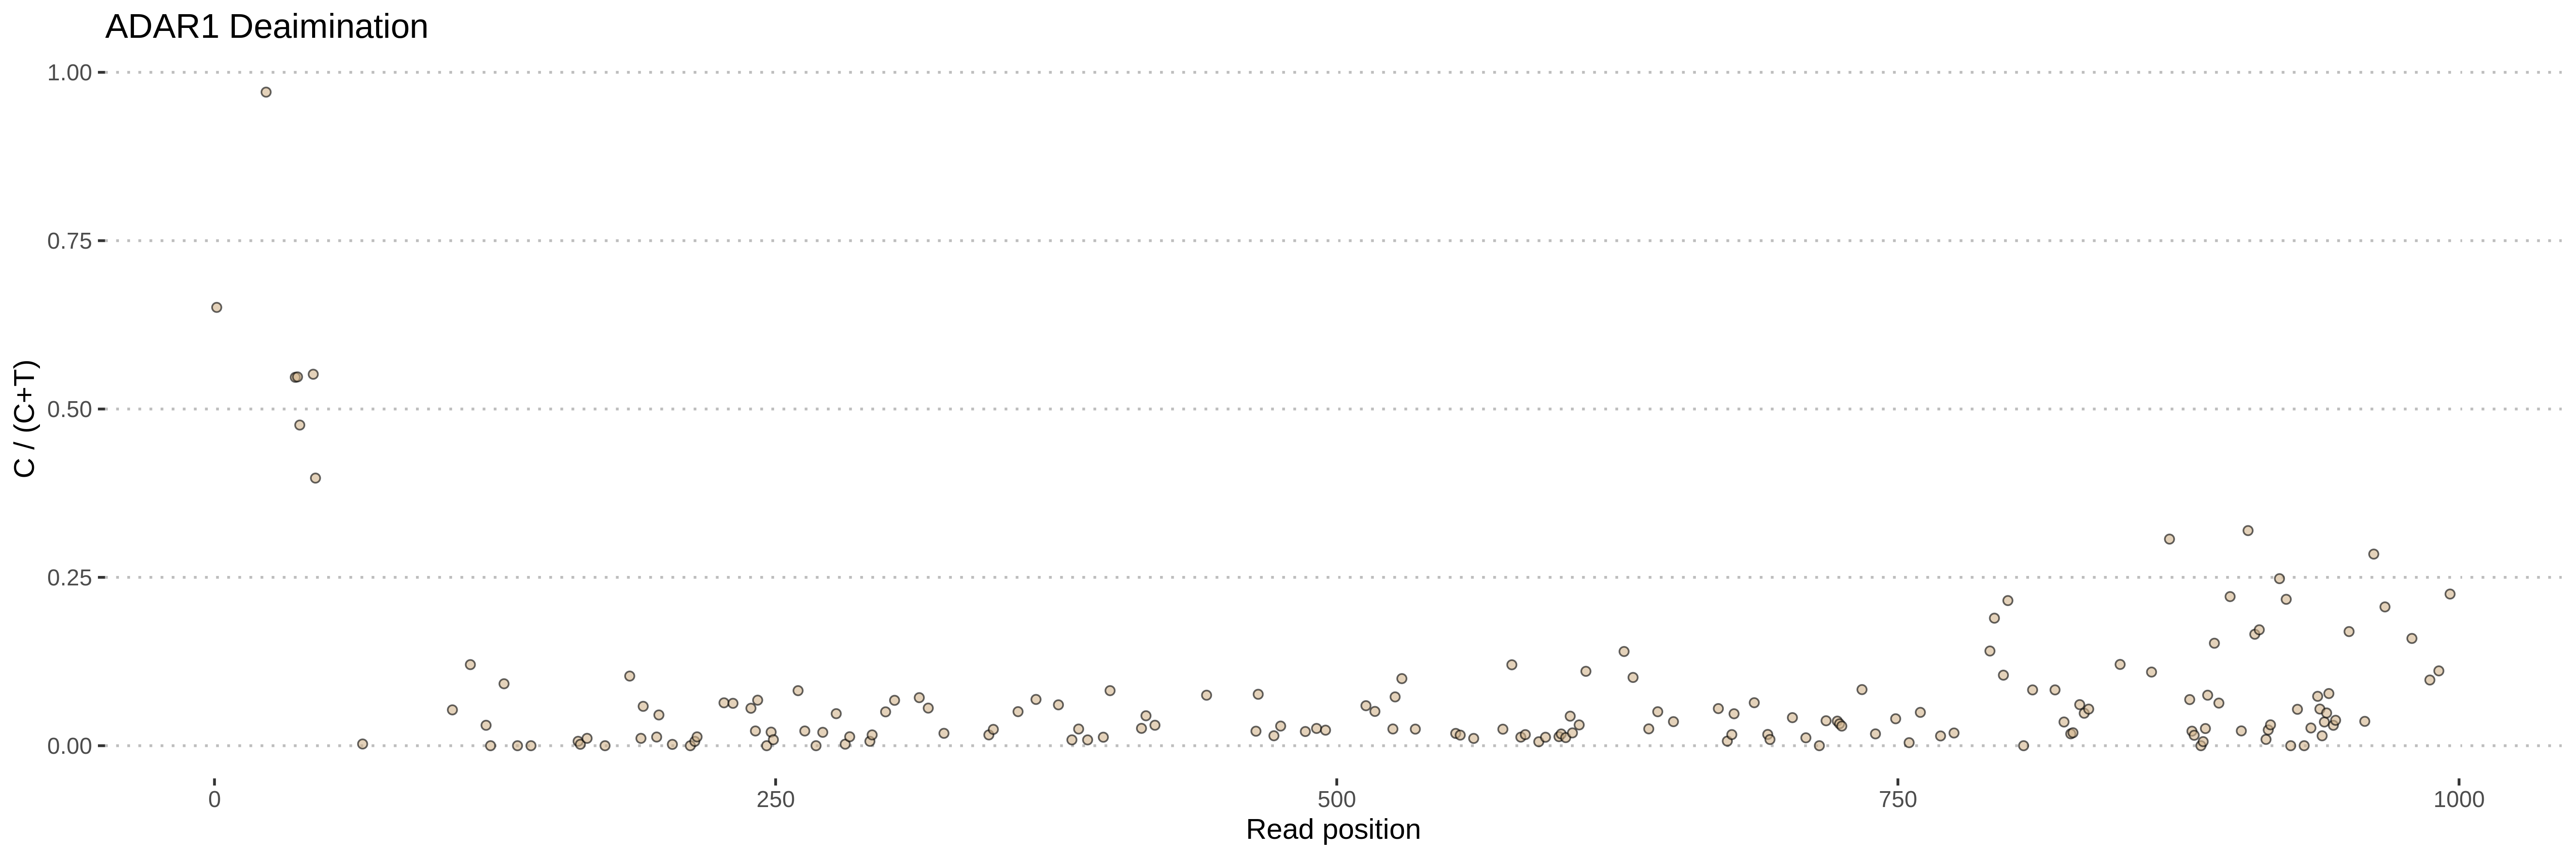

In [43]:
%%R -i all_trace_df_2_T -w 15 -h 5 --units in -r 400

adar1.df.2 <- subset(all_trace_df_2_T, sample_ID==2)

adar1.2.plt <- ggplot(adar1.df.2, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='tan', alpha=0.6) + 
        theme_pubclean() + labs(y='C / (C+T)', x='Read position', title='ADAR1 Deaimination')
adar1.2.plt 

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


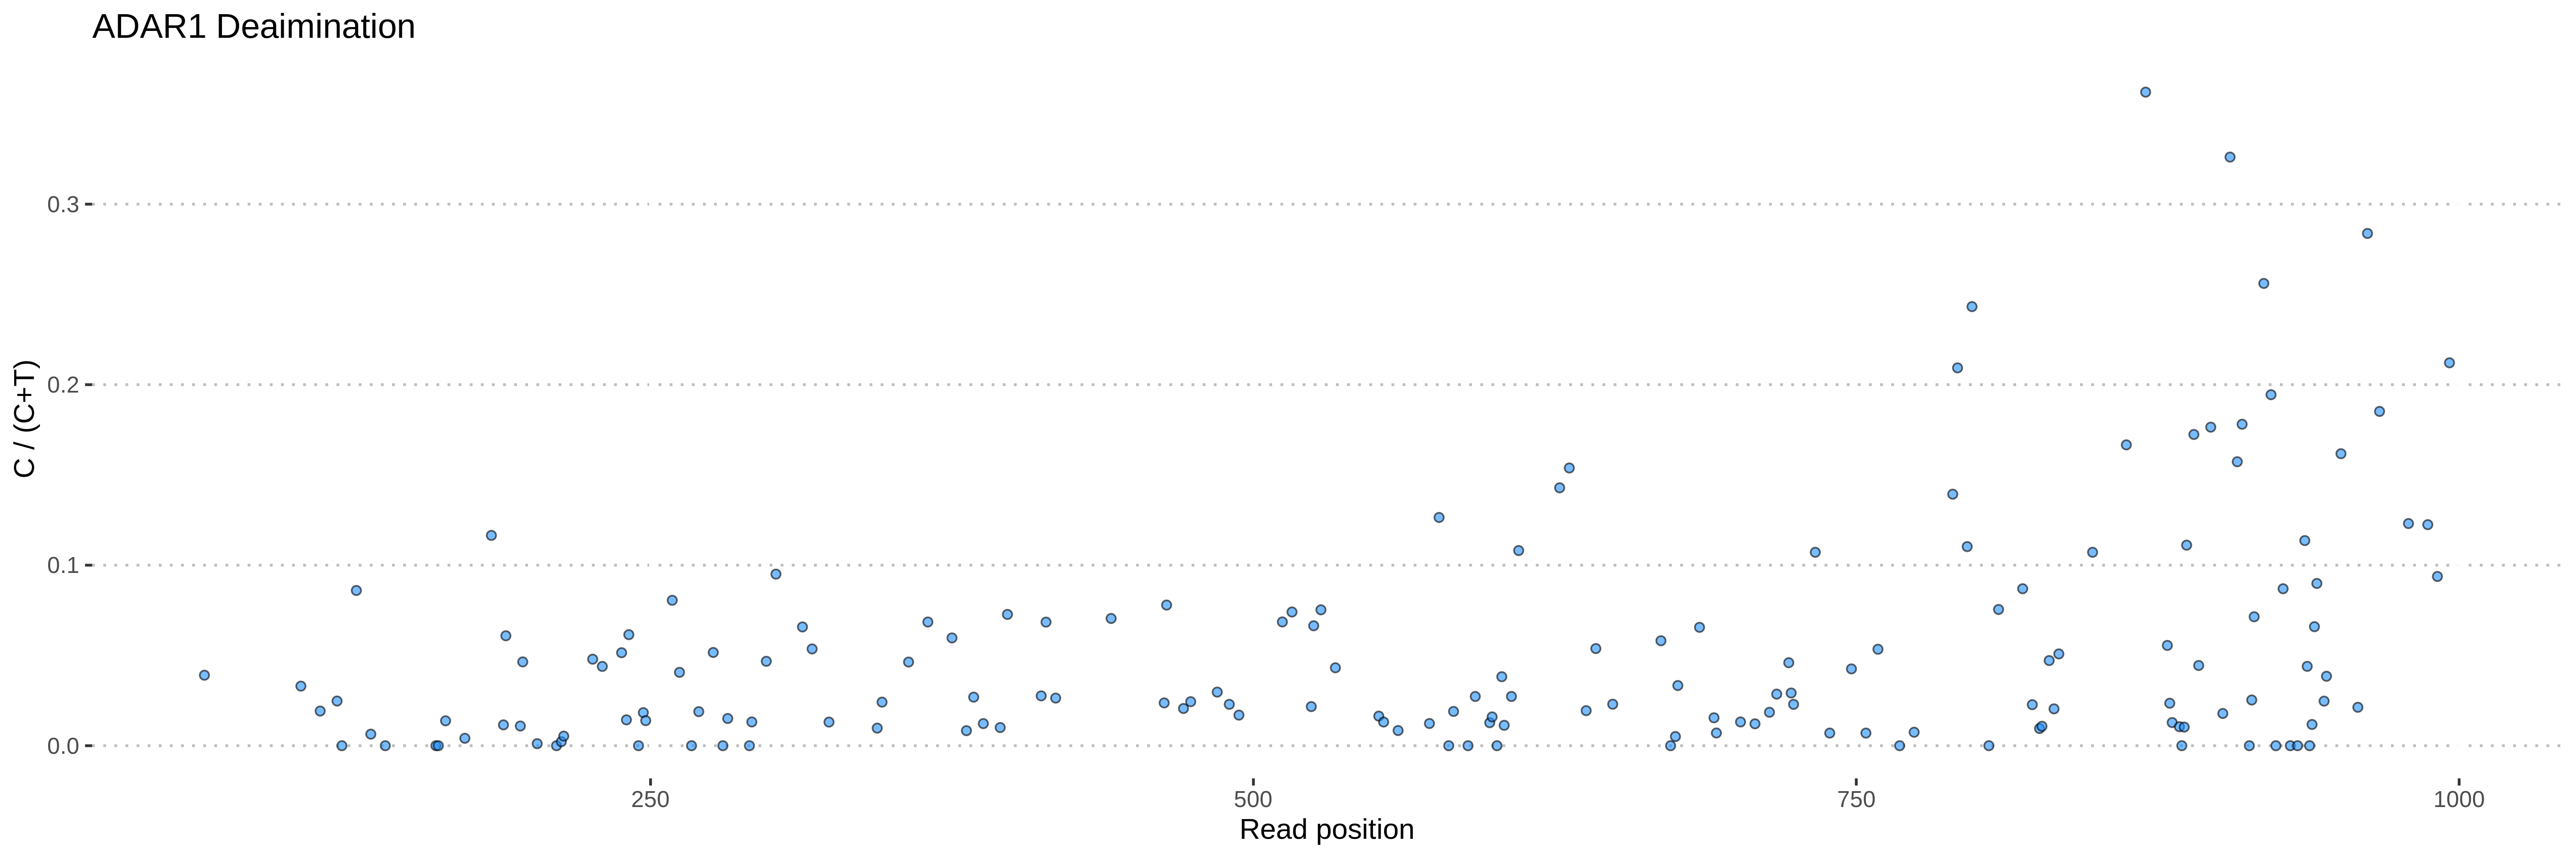

In [44]:
%%R -i all_trace_df_2_T -w 15 -h 5 --units in -r 400

adar1.df.1 <- subset(all_trace_df_2_T, sample_ID==1)

adar1.1.plt <- ggplot(adar1.df.1, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='dodgerblue', alpha=0.6) + 
        theme_pubclean() + labs(y='C / (C+T)', x='Read position', title='ADAR1 Deaimination')

adar1.1.plt 

Ok what about a sample that was not treated with ADAR, sample 10 for instance.

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


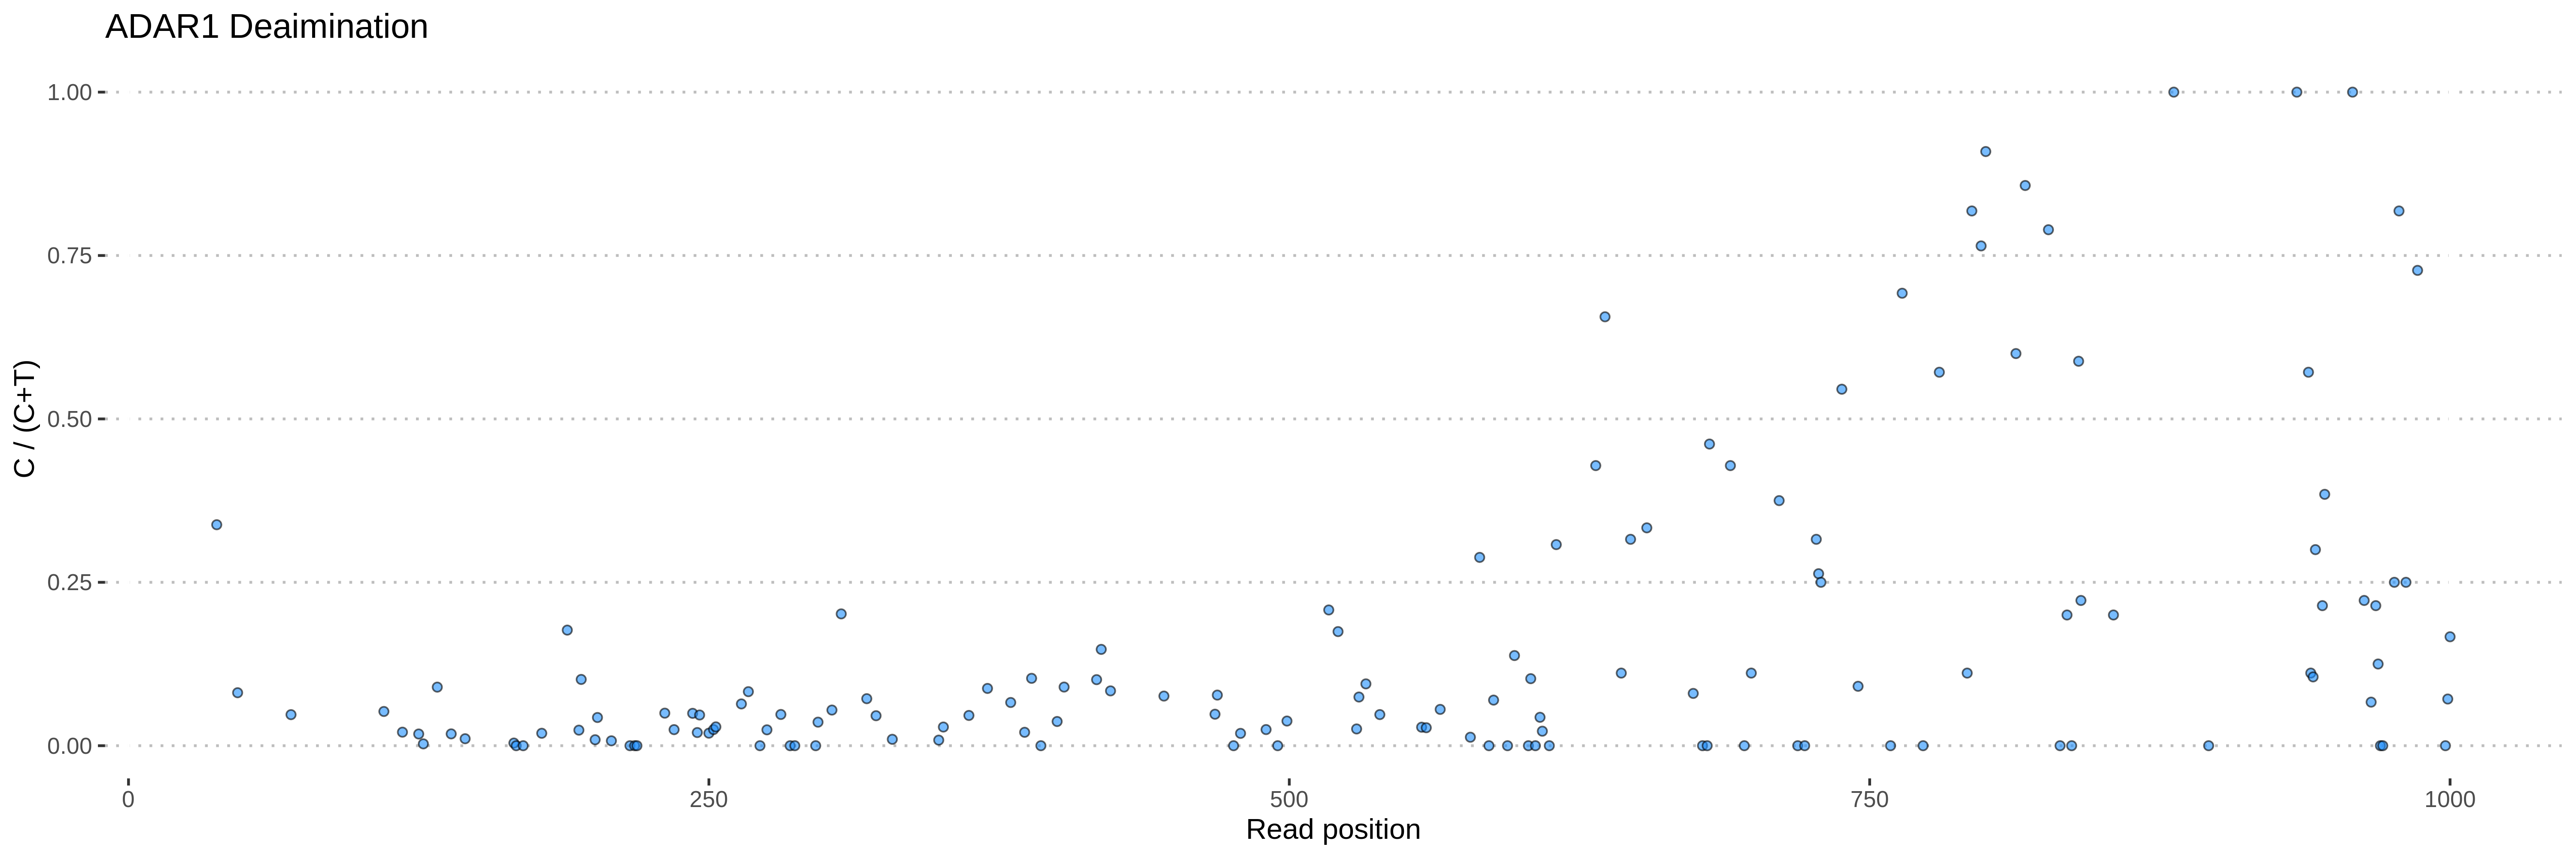

In [45]:
%%R -i all_trace_df_2_T -w 15 -h 5 --units in -r 400

adar1.df.10 <- subset(all_trace_df_2_T, sample_ID==10)

adar1.10.plt <- ggplot(adar1.df.10, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='dodgerblue', alpha=0.6) + 
        theme_pubclean() + labs(y='C / (C+T)', x='Read position', title='ADAR1 Deaimination')

adar1.10.plt 

In [46]:
CTA_sites_2 = identify_cta_sites(all_trace_df_2)

CTA_sites_2.head()

pos  peakA  peakC  peakG  peakT  basenum primary secondary consensus  \
1306  1307     31     45      5    801    106.0       T         T         T   
2119  2120     26      0     91   1005    174.0       T         T         T   
2478  2479      7      2     80   1028    204.0       T         T         T   
2985  2986     62      0     21    962    246.0       T         T         T   
3400  3401     46      2     65    886    281.0       T         T         T   

      qual trim ref_nuc  conversion_ratio  sum_signal  ADAR  insert rnaseh  \
1306  22.0    Y       T          0.053191         882  IDEQ      26      -   
2119  38.0    Y       T          0.000000        1122  IDEQ      26      -   
2478  54.0    Y       T          0.001942        1117  IDEQ      26      -   
2985  59.0    Y       T          0.000000        1045  IDEQ      26      -   
3400  62.0    Y       T          0.002252         999  IDEQ      26      -   

      sample_ID   sample_name  
1306          2  IDEQ + TXN +  
2119          2  IDEQ + TXN +  
2478          2  IDEQ + TXN +  
2985          2  IDEQ + TXN +  
3400          2  IDEQ + TXN +

In [47]:
def add_cta_site_column(df):
    cta_df = identify_cta_sites(df)
    
    cta_sites_basenum = set(cta_df.basenum)
    
    def is_cta_site(row):
        if row.basenum in cta_sites_basenum:
            return 'TRUE'
        else:
            return 'FALSE'
    
    df['CTA_site'] = df.apply(lambda row : is_cta_site(row), axis=1)
    
    return df

all_trace_df_2_CTA = add_cta_site_column(all_trace_df_2)
all_trace_df_2_CTA_T_only = all_trace_df_2_CTA.loc[all_trace_df_2_CTA['ref_nuc'] == 'T']

In [48]:
all_trace_df_2_CTA_T_only

pos  peakA  peakC  peakG  peakT  basenum primary secondary consensus  \
9         10     32    358   1019    192      1.0       T         T         T   
291      292    467    165   1502      5     23.0       T         T         T   
443      444    827    488    399    404     36.0       A         Y         N   
454      455     28    672    590    555     37.0       G         T         N   
466      467     80    420    194    462     38.0       G         G         G   
...      ...    ...    ...    ...    ...      ...     ...       ...       ...   
11603  11604      1     15     11     66    967.0       T         T         T   
11752  11753      0      8     15     57    979.0       T         T         T   
11846  11847     15      6      7     43    987.0       T         T         T   
11894  11895      1      3     17     29    991.0       T         G         N   
11955  11956     22     14      0     52    996.0       T         T         T   

       qual trim ref_nuc  conversion_ratio  sum_signal  ADAR  insert rnaseh  \
9       5.0    Y       T          0.650909        1601  IDEQ      26      -   
291     5.0    Y       T          0.970588        2139  IDEQ      26      -   
443     8.0    Y       T          0.547085        2118  IDEQ      26      -   
454     6.0    Y       T          0.547677        1845  IDEQ      26      -   
466     6.0    Y       T          0.476190        1156  IDEQ      26      -   
...     ...  ...     ...               ...         ...   ...     ...    ...   
11603  31.0    Y       T          0.185185          93  IDEQ      26      -   
11752  31.0    Y       T          0.123077          80  IDEQ      26      -   
11846  26.0    Y       T          0.122449          71  IDEQ      26      -   
11894  14.0    Y       T          0.093750          50  IDEQ      26      -   
11955  28.0    Y       T          0.212121          88  IDEQ      26      -   

       sample_ID    sample_name CTA_site  
9              2   IDEQ + TXN +    FALSE  
291            2   IDEQ + TXN +    FALSE  
443            2   IDEQ + TXN +    FALSE  
454            2   IDEQ + TXN +    FALSE  
466            2   IDEQ + TXN +    FALSE  
...          ...            ...      ...  
11603          1  IDEQ + TXN -     FALSE  
11752          1  IDEQ + TXN -     FALSE  
11846          1  IDEQ + TXN -     FALSE  
11894          1  IDEQ + TXN -     FALSE  
11955          1  IDEQ + TXN -     FALSE  

[832 rows x 20 columns]

/home/ethan/anaconda3/envs/bs/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


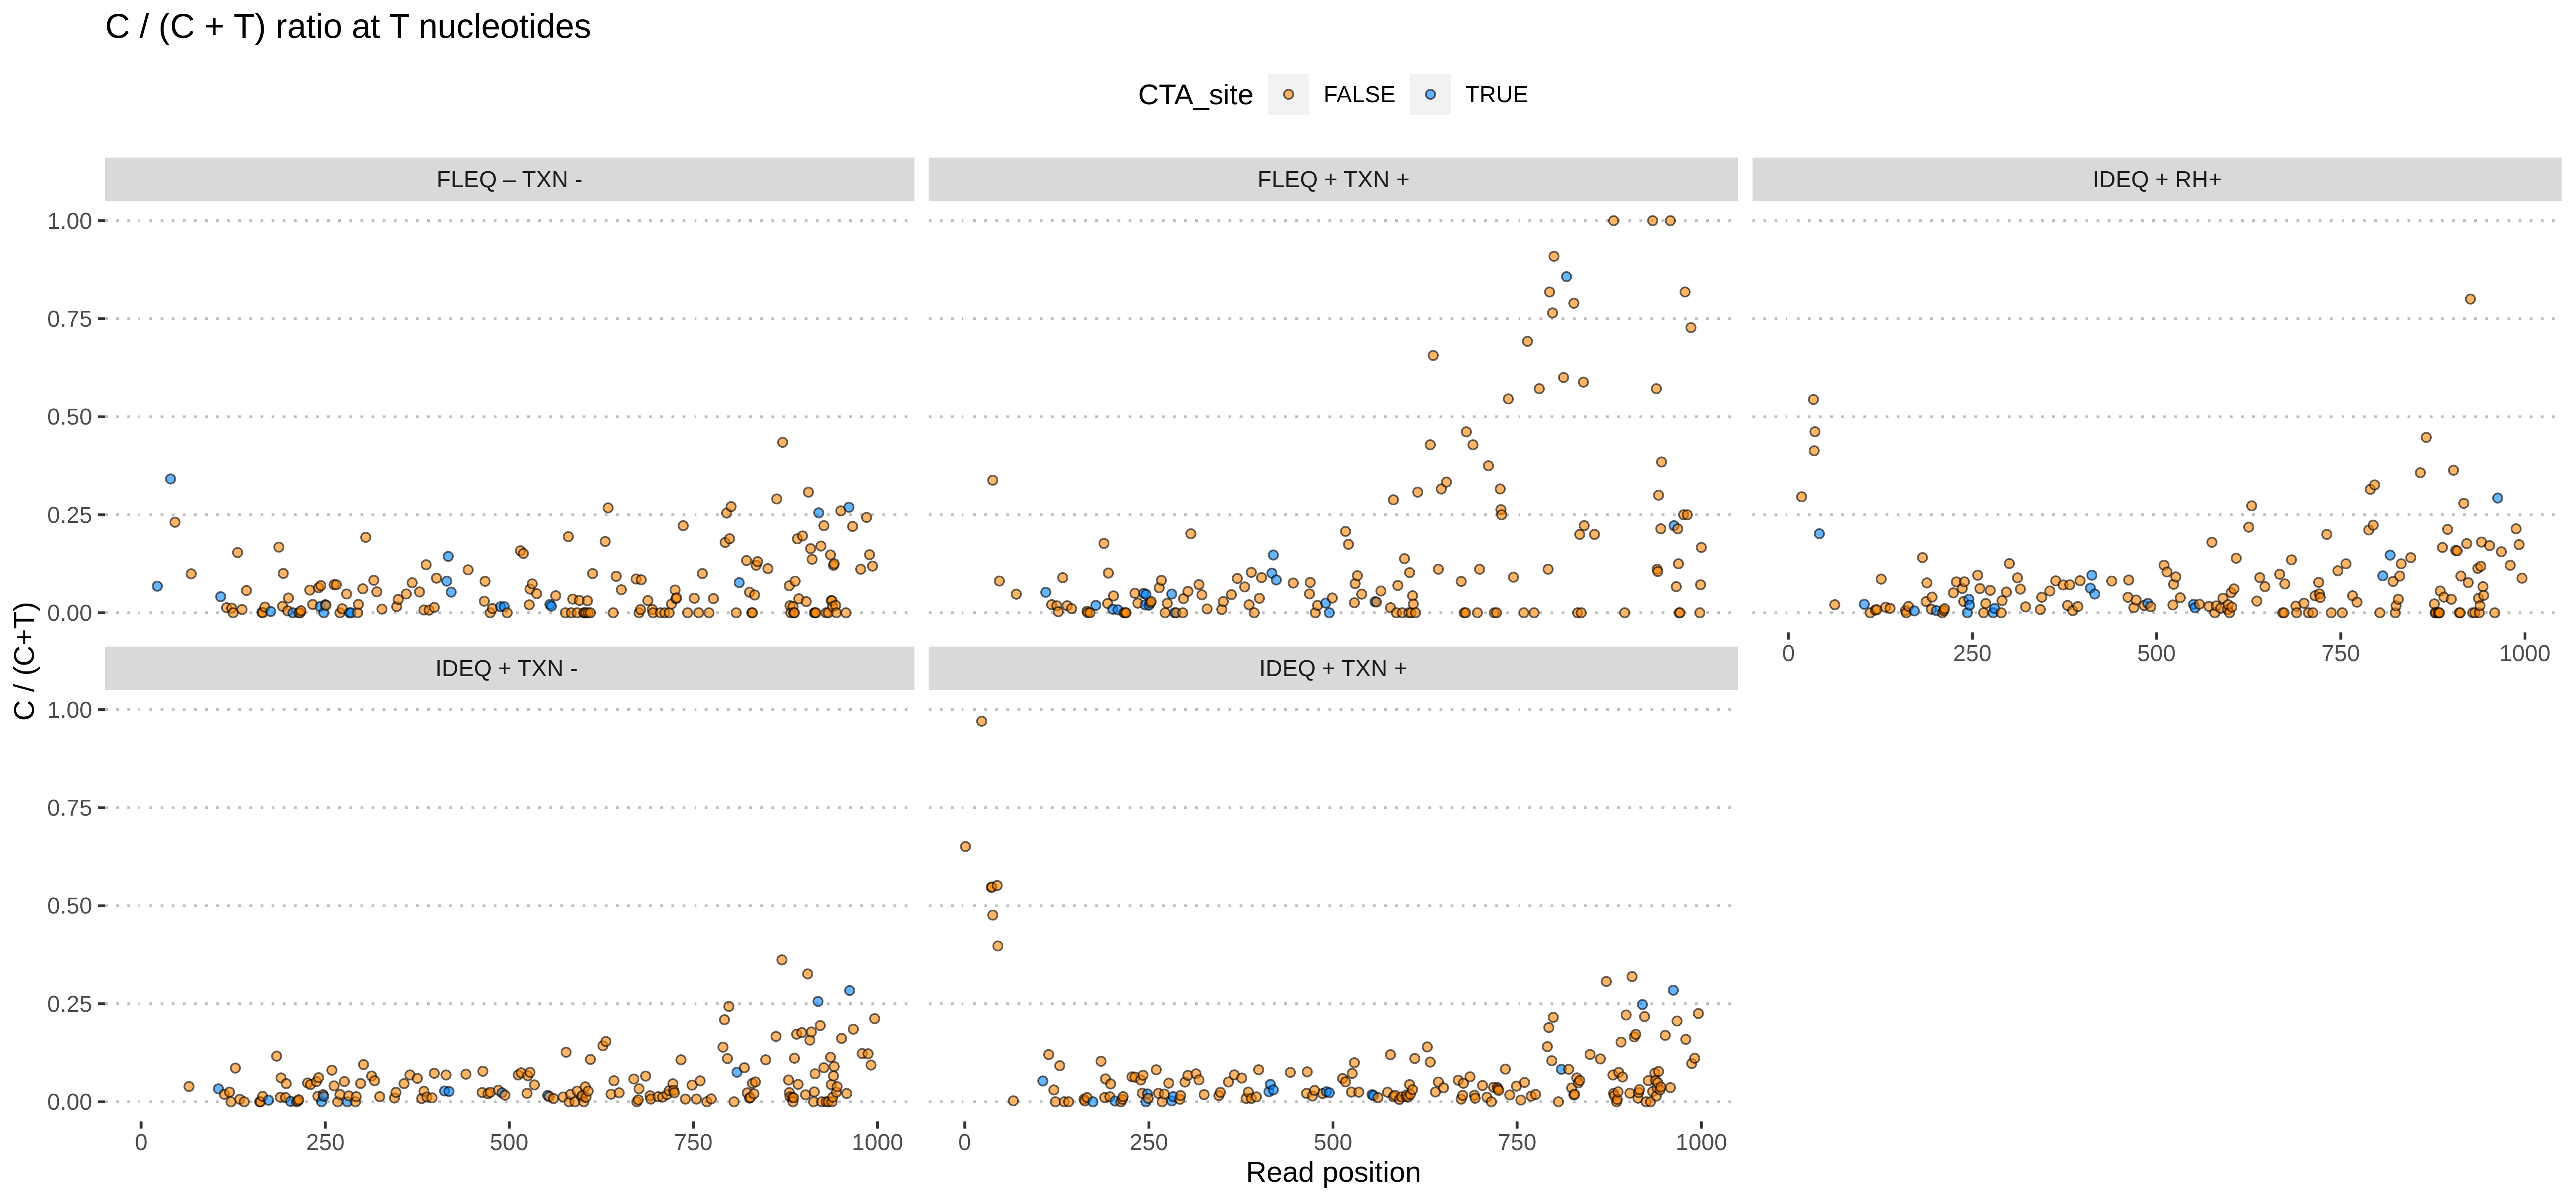

In [56]:
%%R -i all_trace_df_2_CTA_T_only -w 15 -h 7 --units in -r 400


adar1.2.plt <- ggplot(all_trace_df_2_CTA_T_only, aes(x=basenum, y=conversion_ratio, fill=CTA_site)) + 
        geom_point(pch=21, alpha=0.6) + 
        theme_pubclean() + labs(y='C / (C+T)', x='Read position', title='C / (C + T) ratio at T nucleotides') +
        facet_wrap(~sample_name) + scale_fill_manual(values=c('#fc8403', '#0384fc'))

adar1.2.plt 

In [57]:
%%R 

ggsave('plots/sanger-experiment-2-T-nucleotide-analysis-all-samples.png', adar1.2.plt, dpi=600, width=17, height=7)

write this data to a csv file 

In [51]:
all_trace_df_2_CTA.to_csv('ADARReaction2VR26SamplesCRatios.csv', index=False)